# Urdu Speech Emotion Detection using ANN
## Group Members
- Anand Kumar | ak05173
- Ghani Haider | gh05177
- Salman Muhammad Younus | sy04351

colab link : https://colab.research.google.com/drive/1QSPqYhSrkr6UadBHccM6iSwb3jRBQFvc?usp=sharing

## Downloading required libraries

In [ ]:
!sudo apt update

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,622 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [993 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [966 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 Packages [1,257 kB]
Get:12 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,235 kB]
Hit:13 https://ppa.launchpadcontent.net/g

In [ ]:
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg p7zip-full python3-pyaudio

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libasound2-dev is already the newest version (1.2.6.1-1ubuntu1).
p7zip-full is already the newest version (16.02+dfsg-8).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
Suggested packages:
  portaudio19-doc python-pyaudio-doc
The following NEW packages will be installed:
  libportaudio2 libportaudiocpp0 portaudio19-dev python3-pyaudio
0 upgraded, 4 newly installed, 0 to remove and 23 not upgraded.
Need to get 213 kB of archives.
After this operation, 1,043 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudio2 amd64 19.6.0-1.1 [65.3 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 libportaudiocpp0 amd64 19.6.0-1.1 [16.1 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 portaudio19-dev amd64 19.6.0-1.1 [106 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy/universe amd64 python3-pyaudio

In [ ]:
!pip install librosa soundfile numpy sklearn pyaudio

  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


In [ ]:
import librosa
import soundfile
import os, glob, pickle
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

## Downloading the SEMOUR Dataset

In [ ]:
!gdown --id 1UVfeHncEVifIIAKqXoN8OTqbooUbmwhR
!7z x SEMOUR_HD.zip

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Access denied with the following error:

 	Cannot retrieve the public link of the file. You may need to change
	the permission to 'Anyone with the link', or have had many accesses. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1UVfeHncEVifIIAKqXoN8OTqbooUbmwhR 


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.30GHz (306F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         
ERROR: No more files
SEMOUR_HD.zip



System ERROR:
Unknown error -2147024872


In [ ]:
# Extract features (mfcc, chroma, mel) from a sound file
def extract_feature(file_name, mfcc, chroma, mel, axis_=1):
  with soundfile.SoundFile(file_name) as sound_file:
      X = sound_file.read(dtype="float32")
      X = X.mean(axis=axis_)
      sample_rate=sound_file.samplerate
      if chroma:
          stft=np.abs(librosa.stft(X))
      result=np.array([])
      if mfcc:
          mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
          result=np.hstack((result, mfccs))
      if chroma:
          chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
          result=np.hstack((result, chroma))
      if mel:
          mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
          result=np.hstack((result, mel))
  return result

In [ ]:
# Index based mapping of label values for SEMOUR-HD dataset
observed_emotions = ['Sadness', 'Anger', 'Happiness', 'Neutral', 'Surprise', 'Boredom', 'Fearful', 'Disgust']

In [ ]:
# Load the data and extract features for each sound file
def load_data(test_size=0.2):
    x,y=[],[]
    i = 0
    for file in glob.glob("HD-SEMOUR/Actor_*/*/*.wav"):
        file_name=os.path.basename(file)

        emotion = file.split('/')[2]

        if emotion not in observed_emotions:
            continue
        feature=extract_feature(file, mfcc=True, chroma=True, mel=True)
        x.append(feature)
        # get the respective emotion's index and save it
        emotion_index = observed_emotions.index(emotion)
        y.append(emotion_index)

        i+=1

        if i % 100 == 0:
            print(f"{i} files read out of 15042")

    return train_test_split(np.array(x), y, test_size=test_size, random_state=9)


In [ ]:
# Split the dataset
x_train, x_test, y_train, y_test = load_data(test_size=0.3)
y_train = np.array(y_train)
y_test = np.array(y_test)

ValueError: ignored

In [ ]:
# Get the shape of the training and testing datasets
print((x_train.shape[0], x_test.shape[0]))

NameError: ignored

## Making the ANN model

In [ ]:
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense

from tensorflow.keras.optimizers import Adam

In [ ]:
# Get input dimension
input_feature = x_train.shape[1]
print(input_feature)

# Creating our own neutral network model
model = Sequential()
model.add(Dense(256, activation='relu', input_shape=(input_feature,)))
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(8, activation='softmax'))

NameError: ignored

In [ ]:
from tensorflow.keras.losses import SparseCategoricalCrossentropy

# Choosing the optimizer, loss function and evaluation metric
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

NameError: ignored

In [ ]:
model.summary()

# Diagram of the created ANN model
from tensorflow.keras.utils import plot_model
plot_model(model)

NameError: ignored

In [ ]:
# Training the model on given dataset
history = model.fit(x_train, y_train, epochs=50, validation_split=0.2, verbose=1) #verbose = how to see training progress here

Epoch 1/50
264/264 [==============================] - 2s 5ms/step - loss: 1.8062 - accuracy: 0.5068 - val_loss: 1.2078 - val_accuracy: 0.5589
Epoch 2/50
264/264 [==============================] - 1s 5ms/step - loss: 0.8932 - accuracy: 0.6936 - val_loss: 0.9294 - val_accuracy: 0.6781
Epoch 3/50
264/264 [==============================] - 1s 4ms/step - loss: 0.6571 - accuracy: 0.7712 - val_loss: 0.6362 - val_accuracy: 0.7764
Epoch 4/50
264/264 [==============================] - 1s 4ms/step - loss: 0.5143 - accuracy: 0.8235 - val_loss: 0.6597 - val_accuracy: 0.7844
Epoch 5/50
264/264 [==============================] - 1s 5ms/step - loss: 0.4453 - accuracy: 0.8482 - val_loss: 0.5142 - val_accuracy: 0.8262
Epoch 6/50
264/264 [==============================] - 1s 4ms/step - loss: 0.3678 - accuracy: 0.8759 - val_loss: 0.5630 - val_accuracy: 0.8219
Epoch 7/50
264/264 [==============================] - 1s 5ms/step - loss: 0.3371 - accuracy: 0.8834 - val_loss: 0.4551 - val_accuracy: 0.8590
Epoch 

In [ ]:
# Predicting for the test dataset
model.evaluate(x_test, y_test)

142/142 [==============================] - 1s 3ms/step - loss: 0.4400 - accuracy: 0.9165


[0.4400220513343811, 0.9164635539054871]

## Confusion Matrix

In [ ]:
# Creating a confusion matrix
y_pred = model.predict(x_test)
y_result = []
y_pred_list = y_pred.tolist()
temp = 0
for i in range(len(y_pred_list)):
  temp = y_pred_list[i].index(max(y_pred_list[i]))
  y_result.append(temp)

In [ ]:
tf.math.confusion_matrix(y_test, y_result)

<tf.Tensor: shape=(8, 8), dtype=int32, numpy=
array([[562,   2,  11,   0,   0,   4,  24,   3],
       [  4, 505,  14,   0,  14,   0,   6,   4],
       [ 10,   9, 515,   2,   9,   2,  31,   3],
       [  3,   0,   6, 493,   1,  12,   6,   5],
       [  9,  13,  33,   0, 466,   5,  25,  10],
       [  1,   0,   0,   5,   0, 561,   3,   2],
       [ 17,   6,  11,   0,   7,   5, 517,  15],
       [  3,   1,   5,   2,   2,   3,   9, 517]], dtype=int32)>

## Model's Accuracy

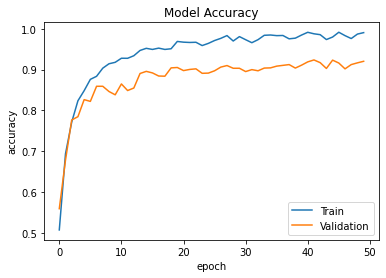

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['Train', 'Validation'])
plt.show()

## Model's Loss

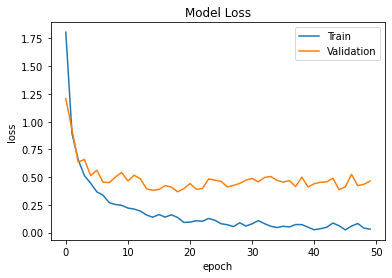

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Train', 'Validation'])
plt.show()

## Other Metrics

In [ ]:
# calculating metrics for a neural network model
from sklearn import metrics

In [ ]:
print("Confusion Matrix:")
print(metrics.confusion_matrix(y_test.tolist(), y_result))
print("\n\n")
print(metrics.classification_report(y_test.tolist(), y_result, digits=3, labels=[0,1,2,3,4,5,6,7], target_names=['Sadness', 'Anger', 'Happiness', 'Neutral', 'Surprise', 'Boredom', 'Fearful', 'Disgust']))

Confusion Matrix:
[[562   2  11   0   0   4  24   3]
 [  4 505  14   0  14   0   6   4]
 [ 10   9 515   2   9   2  31   3]
 [  3   0   6 493   1  12   6   5]
 [  9  13  33   0 466   5  25  10]
 [  1   0   0   5   0 561   3   2]
 [ 17   6  11   0   7   5 517  15]
 [  3   1   5   2   2   3   9 517]]



              precision    recall  f1-score   support

     Sadness      0.923     0.927     0.925       606
       Anger      0.942     0.923     0.933       547
   Happiness      0.866     0.886     0.876       581
     Neutral      0.982     0.937     0.959       526
    Surprise      0.934     0.831     0.879       561
     Boredom      0.948     0.981     0.964       572
     Fearful      0.833     0.894     0.862       578
     Disgust      0.925     0.954     0.939       542

    accuracy                          0.916      4513
   macro avg      0.919     0.917     0.917      4513
weighted avg      0.918     0.916     0.917      4513



# Recording and classifying User Audio

In [ ]:
!pip install ffmpeg-python > /dev/null # for inputting voice via microphone
import IPython.display as ipd
import torchaudio


In [ ]:
# Extract features (mfcc, chroma, mel) from the recorded audio
def recorded_audio_extract_feature(file_name, mfcc, chroma, mel, axis_=1):
  with soundfile.SoundFile(file_name) as sound_file:
      X = sound_file.read(dtype="float32")
      x_np = x.cpu().detach().numpy()
      X = x_np.mean(axis=axis_)
      sample_rate=sound_file.samplerate
      if chroma:
          stft=np.abs(librosa.stft(X))
      result=np.array([])
      if mfcc:
          mfccs=np.mean(librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40).T, axis=0)
          result=np.hstack((result, mfccs))
      if chroma:
          chroma=np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T,axis=0)
          result=np.hstack((result, chroma))
      if mel:
          mel=np.mean(librosa.feature.melspectrogram(X, sr=sample_rate).T,axis=0)
          result=np.hstack((result, mel))
  return result

In [ ]:
# Audio Button and to save recording
# code taken from https://ricardodeazambuja.com/deep_learning/2019/03/09/audio_and_video_google_colab/
from IPython.display import HTML, Audio
from google.colab.output import eval_js
from base64 import b64decode
import numpy as np
import io
import ffmpeg
import tempfile
import pathlib


AUDIO_HTML = """
<script>
var my_div = document.createElement("DIV");
var my_p = document.createElement("P");
var my_btn = document.createElement("BUTTON");
var t = document.createTextNode("Press to start recording");

my_btn.appendChild(t);
//my_p.appendChild(my_btn);
my_div.appendChild(my_btn);
document.body.appendChild(my_div);

var base64data = 0;
var reader;
var recorder, gumStream;
var recordButton = my_btn;

var handleSuccess = function(stream) {
  gumStream = stream;
  var options = {
    //bitsPerSecond: 8000, //chrome seems to ignore, always 48k
    mimeType : 'audio/webm;codecs=opus'
    //mimeType : 'audio/webm;codecs=pcm'
  };
  //recorder = new MediaRecorder(stream, options);
  recorder = new MediaRecorder(stream);
  recorder.ondataavailable = function(e) {
    var url = URL.createObjectURL(e.data);
    var preview = document.createElement('audio');
    preview.controls = true;
    preview.src = url;
    document.body.appendChild(preview);

    reader = new FileReader();
    reader.readAsDataURL(e.data);
    reader.onloadend = function() {
      base64data = reader.result;
      //console.log("Inside FileReader:" + base64data);
    }
  };
  recorder.start();
  };

recordButton.innerText = "Recording... press to stop";

navigator.mediaDevices.getUserMedia({audio: true}).then(handleSuccess);


function toggleRecording() {
  if (recorder && recorder.state == "recording") {
      recorder.stop();
      gumStream.getAudioTracks()[0].stop();
      recordButton.innerText = "Saving the recording... pls wait!"
  }
}

// https://stackoverflow.com/a/951057
function sleep(ms) {
  return new Promise(resolve => setTimeout(resolve, ms));
}

var data = new Promise(resolve=>{
//recordButton.addEventListener("click", toggleRecording);
recordButton.onclick = ()=>{
toggleRecording()

sleep(2000).then(() => {
  // wait 2000ms for the data to be available...
  // ideally this should use something like await...
  //console.log("Inside data:" + base64data)
  resolve(base64data.toString())

});

}
});

</script>
"""

def get_audio():
  display(HTML(AUDIO_HTML))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])

  process = (ffmpeg
    .input('pipe:0')
    .output('pipe:1', format='wav')
    .run_async(pipe_stdin=True, pipe_stdout=True, pipe_stderr=True, quiet=True, overwrite_output=True)
  )
  output, err = process.communicate(input=binary)

  riff_chunk_size = len(output) - 8
  # Break up the chunk size into four bytes, held in b.
  q = riff_chunk_size
  b = []
  for i in range(4):
      q, r = divmod(q, 256)
      b.append(r)

  # Replace bytes 4:8 in proc.stdout with the actual size of the RIFF chunk.
  riff = output[:4] + bytes(b) + output[8:]

  path = "saved/temp.wav"
  with open(path, "wb") as f:
    f.write(riff)
  x, sr = torchaudio.load(path)

  return x, sr

In [ ]:
# record the audio
x, sr = get_audio()

FileNotFoundError: ignored

In [ ]:
# play the audio
print(f'We loaded a speech example; sample rate: {sr}, number of channels: {x.size(0)}, its length is {x.size(1)} frames or about {x.size(1) // sr} seconds.')
ipd.Audio(x, rate=sr)

## Feature Extraction and prediction of the recorded audio
Predicting and plotting the output of the extracted features from the recorded audio.

In [ ]:
# Feature extraction
feature=recorded_audio_extract_feature("saved/temp.wav", mfcc=True, chroma=True, mel=True, axis_=0)

# Prediction
x = [feature]
x = np.array(x)
pred_out = model.predict(x)

# observed emotions = ['Sadness', 'Anger', 'Happiness', 'Neutral', 'Surprise', 'Boredom', 'Fearful', 'Disgust']
val = pred_out.tolist()
pred = val[0].index(max(val[0]))
print(observed_emotions[pred])

## Plotting the extracted features

In [ ]:
# Extract features (mfcc, chroma, mel) from the recorded audio for plotting
def extract_single_feature(file_name, spectogram=False, mfcc=False, chroma=False, mel=False, axis_=1):
  with soundfile.SoundFile(file_name) as sound_file:
      X, sample_rate = librosa.load(path=file_name, dtype="float32")

      if spectogram:
        D = librosa.stft(y=X)  # STFT of y
        S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)
        return S_db

      if chroma:
          stft=np.abs(librosa.stft(X))

      if mfcc:
          return librosa.feature.mfcc(y=X, sr=sample_rate, n_mfcc=40)

      if chroma:
          return librosa.feature.chroma_stft(S=stft, sr=sample_rate)

      if mel:
          return librosa.feature.melspectrogram(X, sr=sample_rate, fmax=8000)

In [ ]:
import librosa.display
fig, ax = plt.subplots()

S_db = extract_single_feature(file_name="saved/temp.wav", spectogram=True, axis_=0)

img = librosa.display.specshow(S_db, x_axis='time', y_axis='linear', ax=ax)
ax.set(title='Spectogram')
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [ ]:
fig, ax = plt.subplots()

S = extract_single_feature(file_name="saved/temp.wav", mel=True, axis_=0)

S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time',
                         y_axis='mel', sr=sr,
                         fmax=8000, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title='Mel-frequency spectrogram')

In [ ]:
fig, ax = plt.subplots()

mfcc_to_plot = extract_single_feature(file_name="saved/temp.wav", mfcc=True, axis_=0)

img = librosa.display.specshow(mfcc_to_plot, x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='MFCC')

In [ ]:
fig, ax = plt.subplots()

chroma_to_plot = extract_single_feature(file_name="saved/temp.wav", chroma=True, axis_=0)

img = librosa.display.specshow(chroma_to_plot, y_axis='chroma', x_axis='time', ax=ax)
fig.colorbar(img, ax=ax)
ax.set(title='Chromagram')